In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import json
import cv2



In [2]:
with open('train_annotations', 'r') as file:
    content = file.read()

data = json.loads(content)

FAST_RUN = False
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:
filenames = os.listdir("train/train/")
categories = []
images = []
number = 0
for filename in filenames:
    categories.append(data[number]['category_id'])
    number += 1
    image = cv2.imread(filename)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # image = cv2.GaussianBlur(image, (5, 5), 0)

    # kernel = np.ones((3, 3), np.uint8)
    # image = cv2.erode(image, kernel, iterations=1)

    # _, image = cv2.threshold(image, 0, 255, cv2.THRESH_TRIANGLE)

    images.append(image)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
print(len(images))


500


In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 318, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 318, 318, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 159, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 159, 159, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 157, 157, 64)      2

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

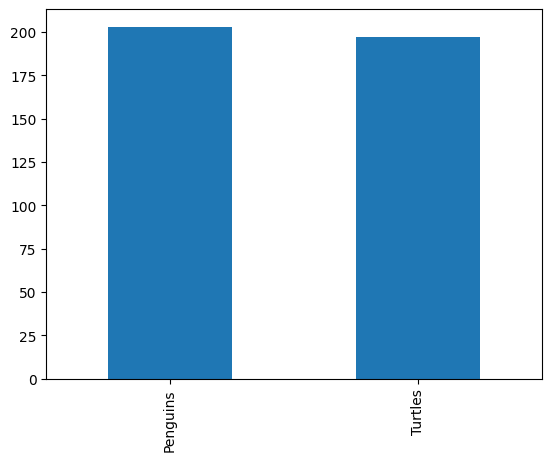

In [10]:
callbacks = [earlystop, learning_rate_reduction]
df["category"] = df["category"].replace({1: 'Penguins', 2: 'Turtles'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
train_df['category'].value_counts().plot.bar()
validate_df['category'].value_counts().plot.bar()
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 400 validated image filenames belonging to 2 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)
print(validation_generator)

Found 0 validated image filenames belonging to 0 classes.


c:\Users\12648\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 100 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [13]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [1]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

# print(train_generator.shape)

NameError: name 'FAST_RUN' is not defined

In [ ]:
model.save_weights("model.h5")

In [ ]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
# ax1.plot(history.history['loss'], color='b', label="Training loss")
# ax1.plot(history.history['val_loss'], color='r', label="validation loss")
# ax1.set_xticks(np.arange(1, epochs, 1))
# ax1.set_yticks(np.arange(0, 1, 0.1))

# ax2.plot(history.history['acc'], color='b', label="Training accuracy")
# ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
# ax2.set_xticks(np.arange(1, epochs, 1))

# legend = plt.legend(loc='best', shadow=True)
# plt.tight_layout()
# plt.show()

In [ ]:
test_filenames = os.listdir("valid/valid/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "valid/valid/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)


In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({1: 'Penguins', 2: 'Turtles'})


In [ ]:
test_df['category'].value_counts().plot.bar()


In [ ]:
sample_test = test_df.head(72)
sample_test.head()
plt.figure(figsize=(24, 48))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("valid/valid/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(24, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()